In [2]:
from wrangling import G,X_test,X_train,y_test,y_train
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
#import seaborn as sns
from torch_geometric.data import Data
import pandas as pd

In [3]:
X_train.shape

(1261, 36, 48)

In [4]:
y_train.shape

(36, 1261)

In [5]:
[1,2] + [3,4]

[1, 2, 3, 4]

In [6]:
y = []
for i in range(36):
    
    whole = list(y_train[i,:]) + list(y_test[i,:])
    y.append(whole)

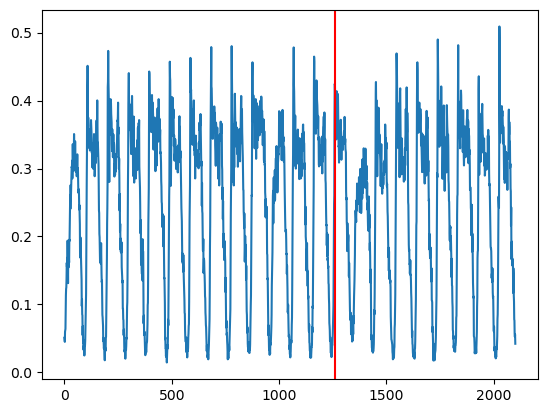

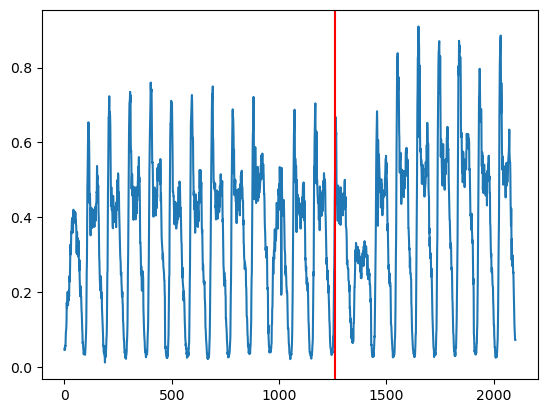

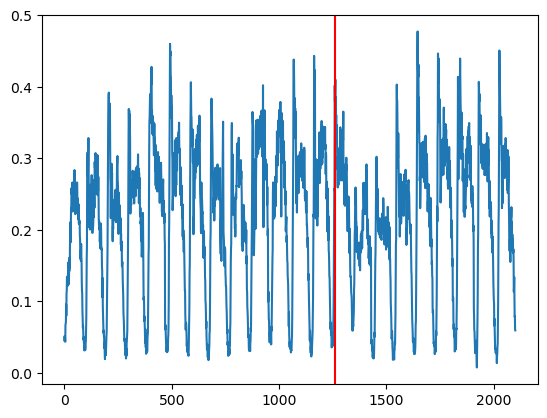

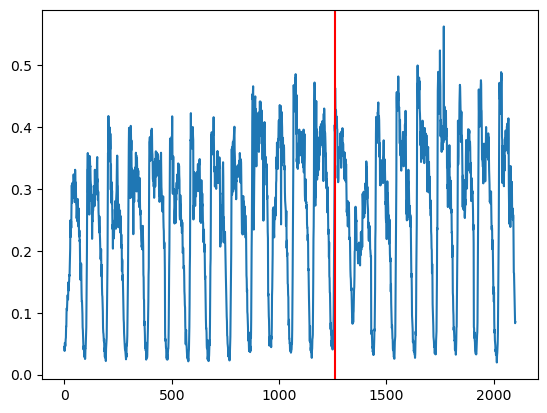

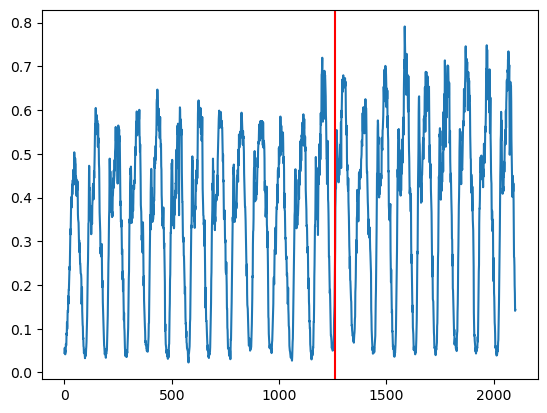

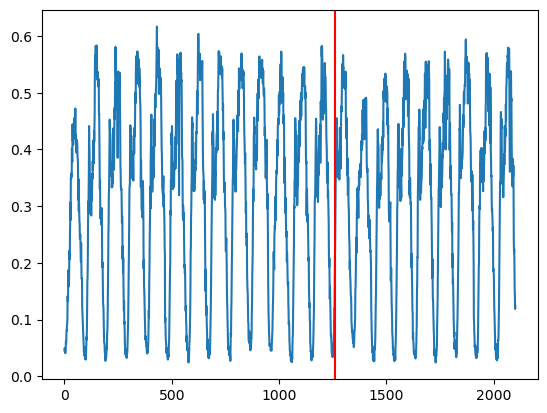

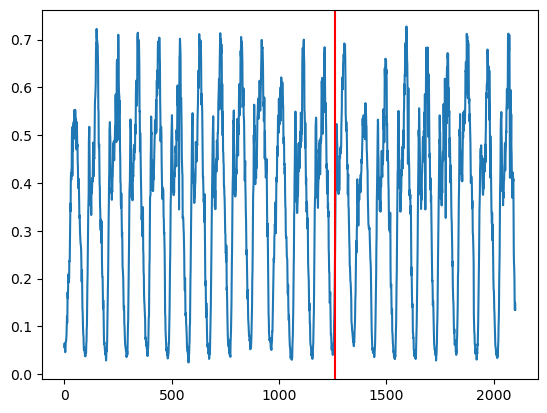

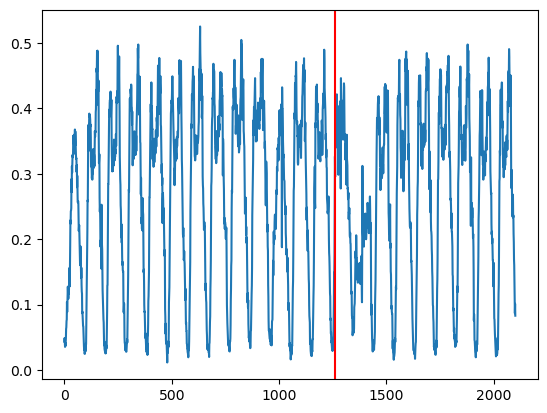

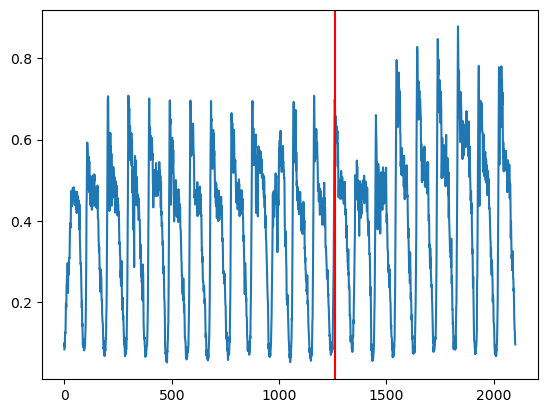

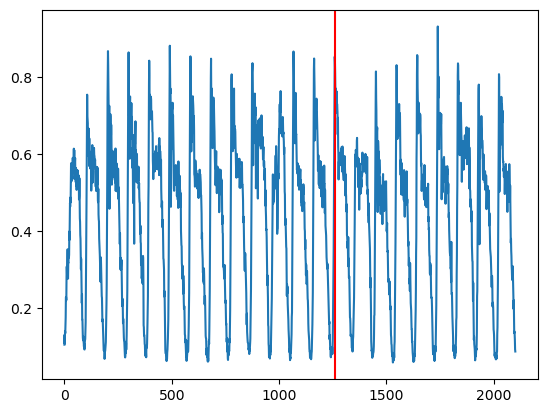

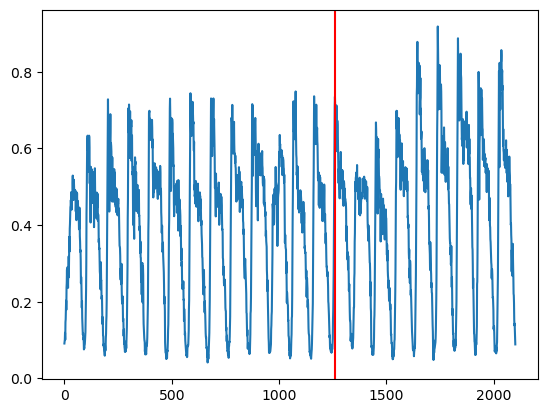

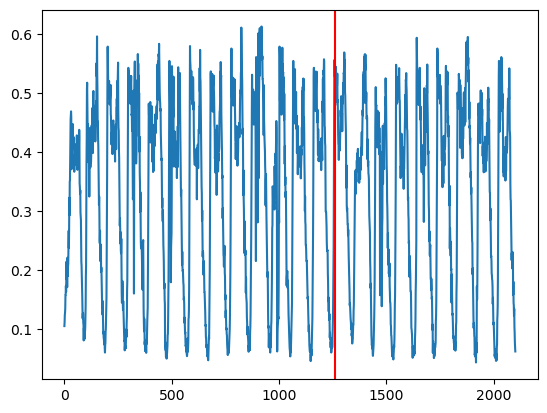

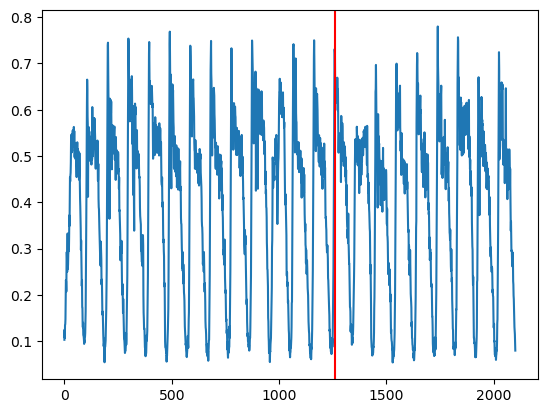

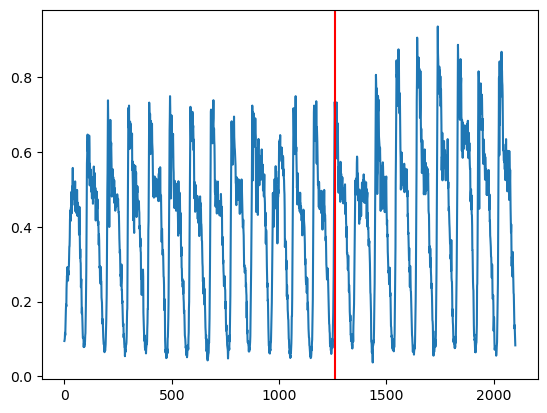

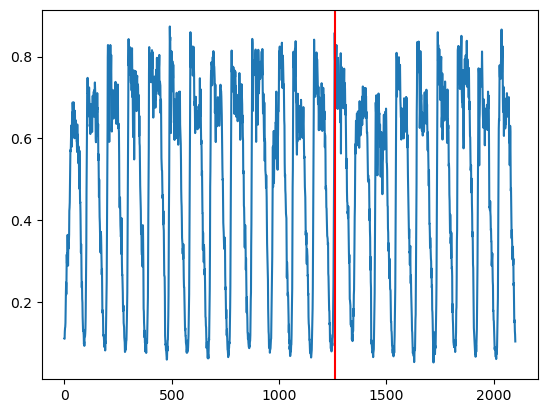

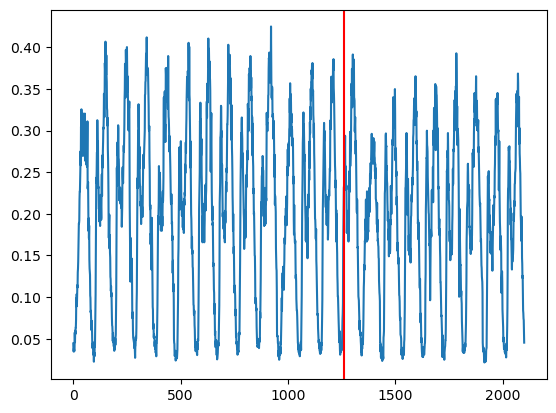

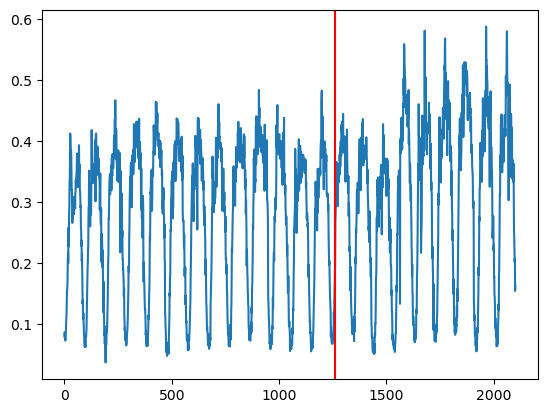

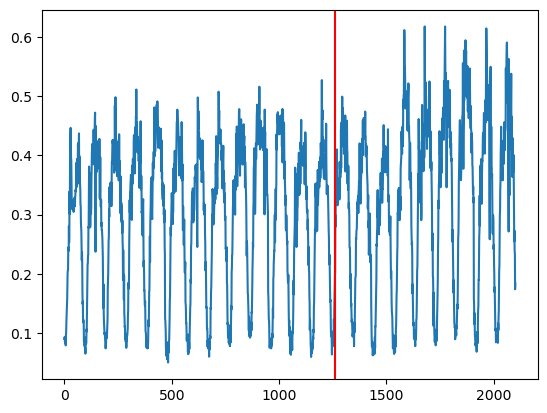

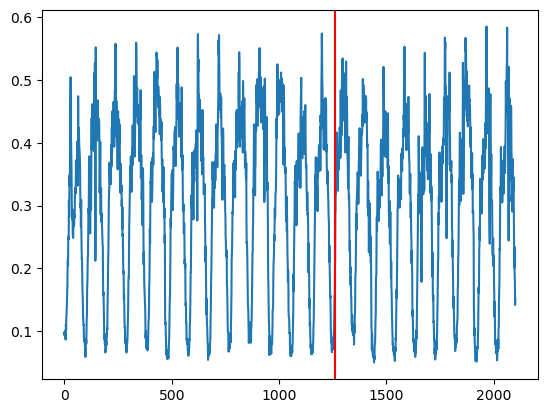

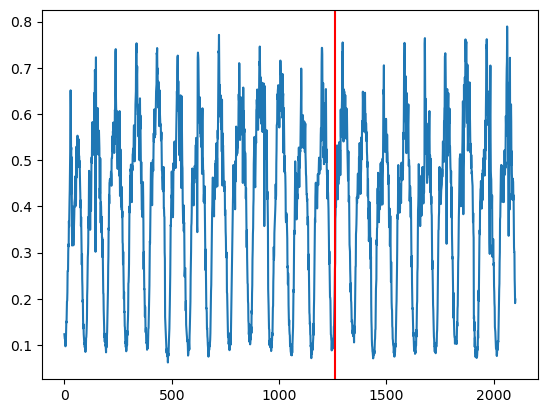

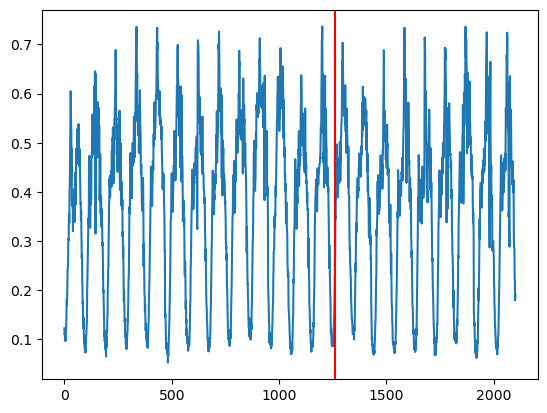

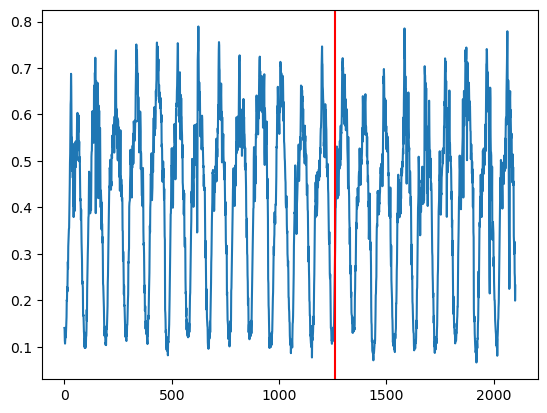

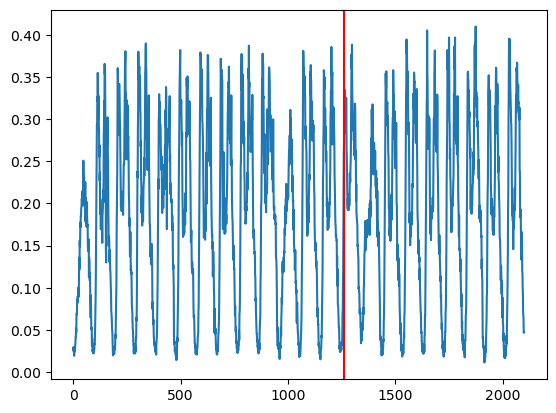

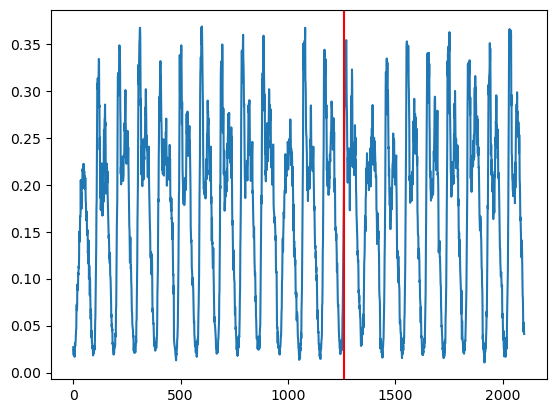

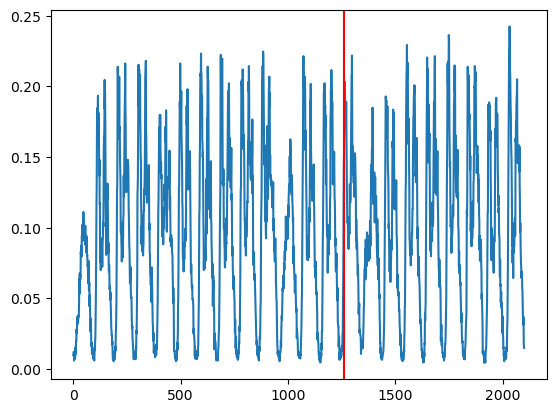

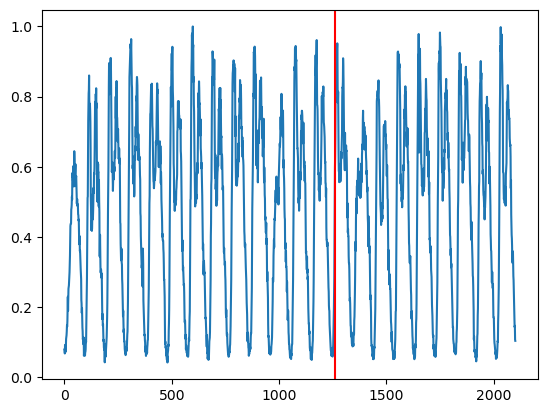

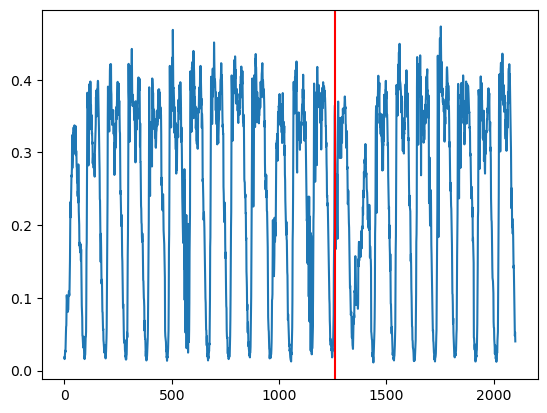

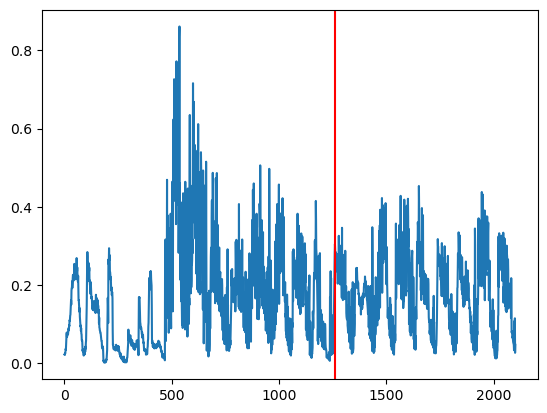

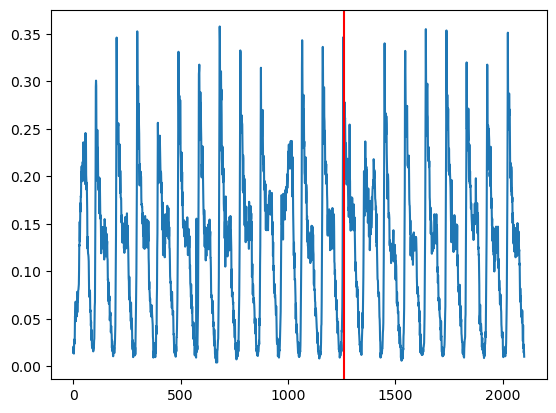

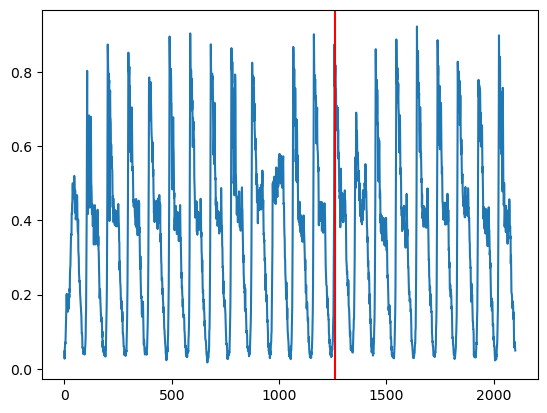

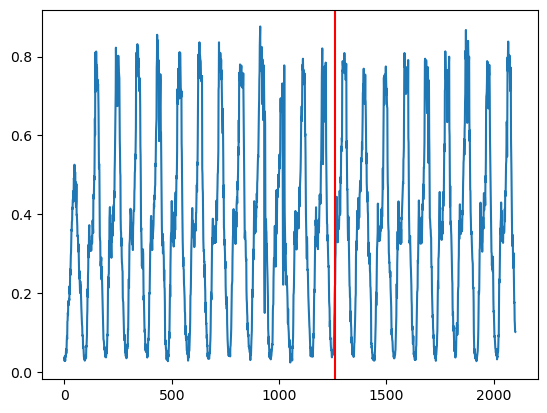

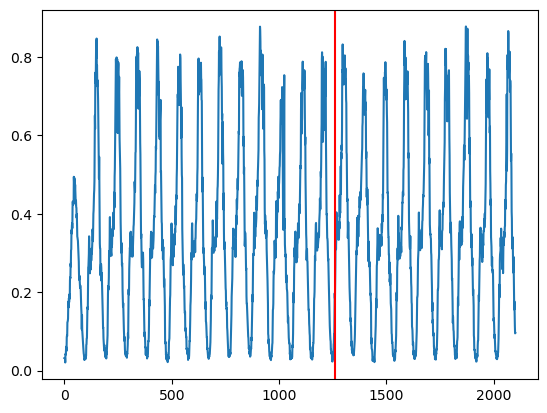

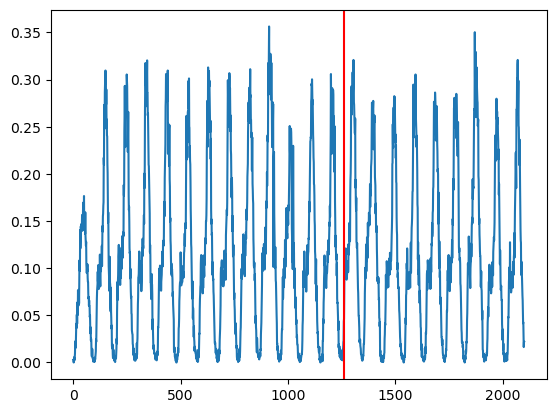

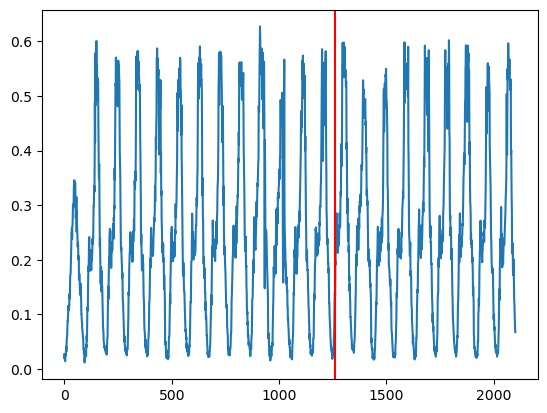

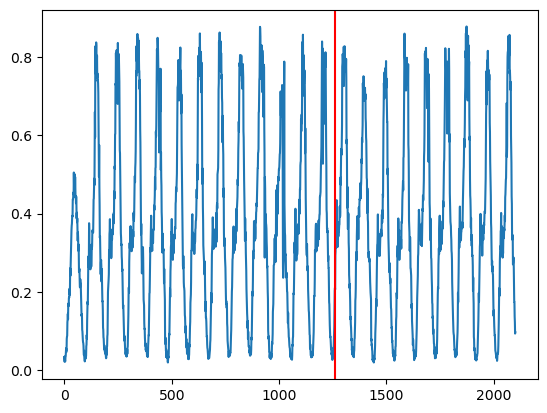

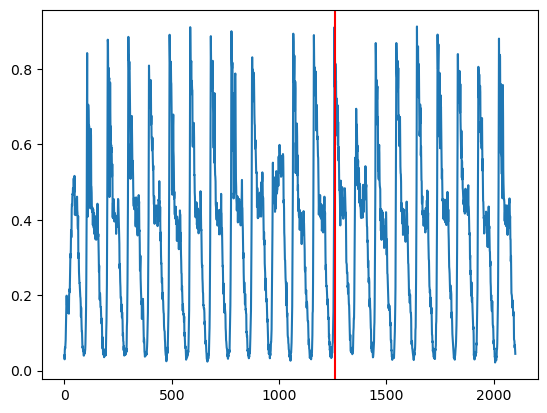

In [7]:
for s in y:
    plt.plot(s)
    plt.axvline(1261,color='red')
    plt.show()


In [8]:
from torch_geometric_temporal.signal import StaticGraphTemporalSignal

train_iter = StaticGraphTemporalSignal(
    edge_index= np.array(list(G.edges())).transpose(),
    edge_weight=np.ones(len(G.edges)),
    features = X_train,
    targets = y_train.T#[4,:].reshape((1261,1))
)

test_iter = StaticGraphTemporalSignal(
    edge_index= np.array(list(G.edges())).transpose(),
    edge_weight=np.ones(len(G.edges)),
    features = X_test,
    targets = y_test.T#[4,:].reshape((840,1))
)


In [9]:
import torch
import torch.nn.functional as F
from torch import nn
from torch_geometric_temporal.nn.recurrent import GConvLSTM

class GLSTM(torch.nn.Module):
    def __init__(self, node_features, filters,num_edges):
        super(GLSTM, self).__init__()
        self.recurrent = GConvLSTM(node_features, filters, 4)
        self.linear = nn.Linear(filters,1)                           
        self.edge_weight = nn.Parameter(torch.ones(num_edges,dtype=torch.float))
        
    def forward(self, x, edge_index, hidden_state, cell_state):
        
        h,c = self.recurrent(x, edge_index, self.edge_weight,H=hidden_state,C=cell_state)
        
        y = F.sigmoid(h)
        y = self.linear(y)

        return y,h,c

In [10]:
from tqdm import tqdm

train_losses = []
test_losses = []

for i in range(36):
    train_iter = StaticGraphTemporalSignal(
        edge_index= np.array(list(G.edges())).transpose(),
        edge_weight=np.ones(len(G.edges)),
        features = X_train,
        targets = y_train[i,:].reshape((1261,1))
    )

    test_iter = StaticGraphTemporalSignal(
        edge_index= np.array(list(G.edges())).transpose(),
        edge_weight=np.ones(len(G.edges)),
        features = X_test,
        targets = y_test[i,:].reshape((840,1))
    )

   

    batch_size = 4
    model = GLSTM(node_features=48,filters=29,num_edges=43)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    tr_preds = []
    tr_y = []

    train_loss = []
    test_loss = []
    t = tqdm(range(100),leave=True)

    for epoch in t:
        model.train()
        
        H = None
        C = None
        cost = torch.zeros(1)
        for time, snapshot in enumerate(train_iter):
            y_hat,H,C = model(snapshot.x, snapshot.edge_index, H, C)
            cost = cost + torch.mean((y_hat-snapshot.y)**2)
            if time == batch_size:
                train_loss.append(cost.detach()/(batch_size+1))
            if time%batch_size == 0 or time == 1260:
                cost.backward()
                optimizer.step()
                optimizer.zero_grad()
                cost = 0
                H = None
                C = None
        with torch.no_grad():
            H_t = None
            C_t = None
            model.eval()
            test_cost = 0
            for ttime, tsnapshot in enumerate(test_iter):
                pred,H_t,C_t = model(tsnapshot.x, tsnapshot.edge_index, H_t,C_t)
                test_cost = test_cost + torch.mean((pred-tsnapshot.y)**2)

                if ttime%batch_size == 0:
                    H_t = None
                    C_t = None
            test_cost = test_cost / (ttime+1)
            test_cost = test_cost.item()
            test_loss.append(test_cost)
        
        t.set_description(f'train MSE:{train_loss[-1]:3f}, test MSE:{test_loss[-1]:3f}')
        if epoch > 15:
            if test_loss[-1] > test_loss[-2] and test_loss[-2] > test_loss[-3] and test_loss[-3] > test_loss[-4]:
                break
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    

  0%|          | 0/100 [00:00<?, ?it/s]

train MSE:0.000869, test MSE:0.004318: 100%|██████████| 100/100 [14:47<00:00,  8.88s/it]


0

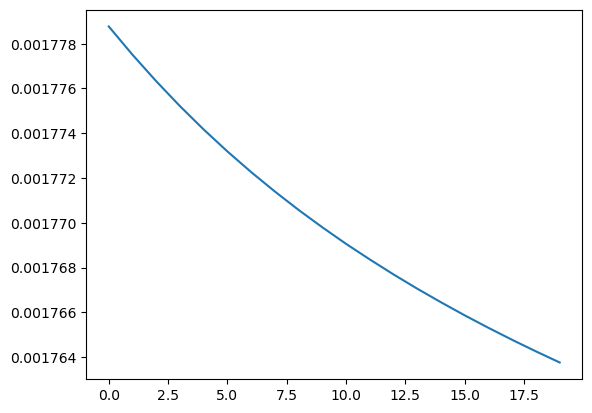

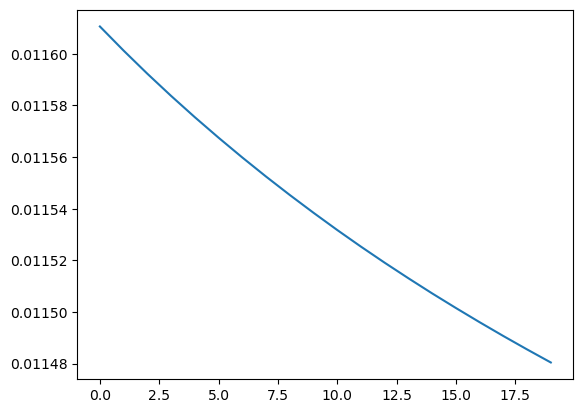

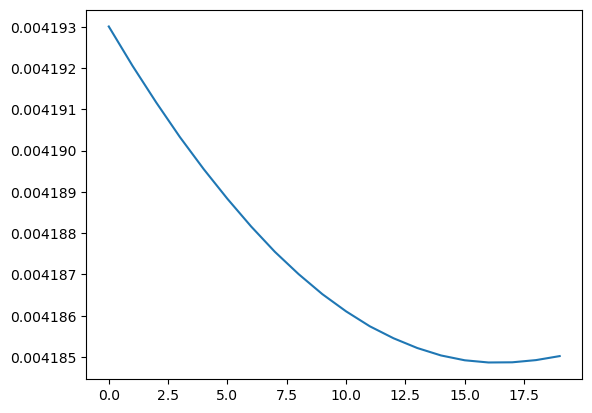

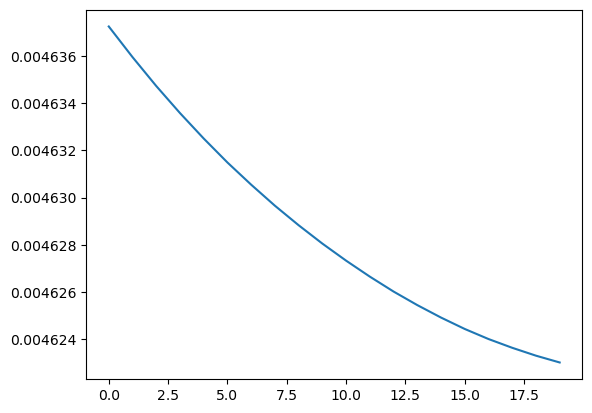

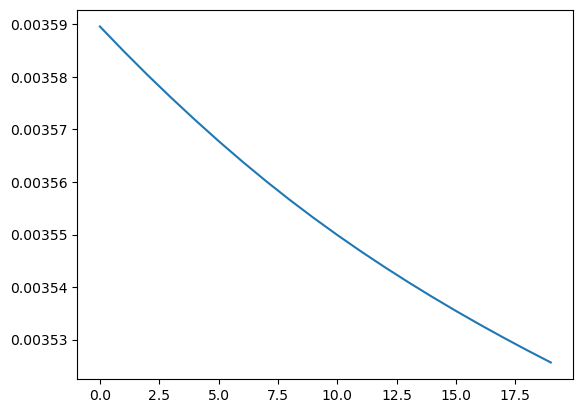

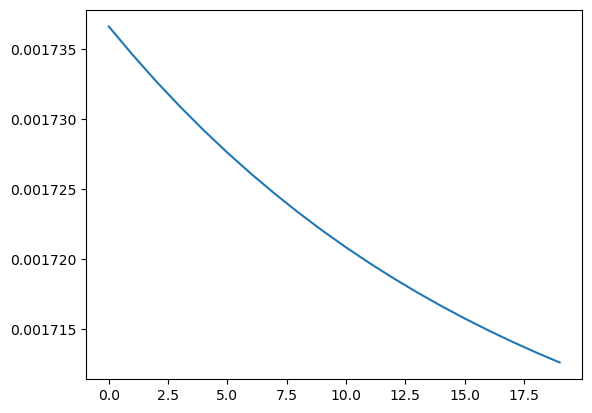

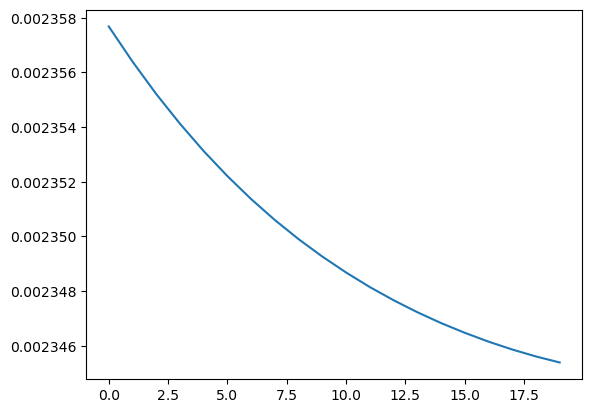

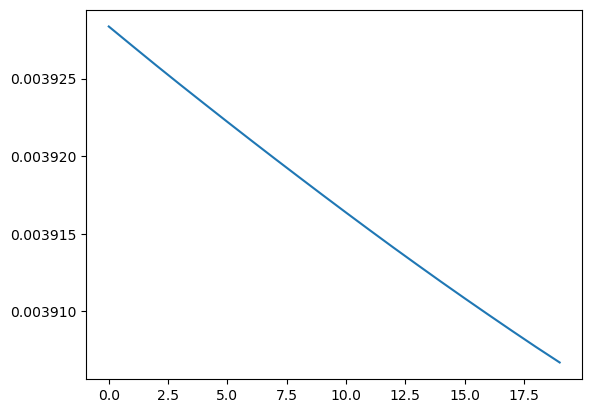

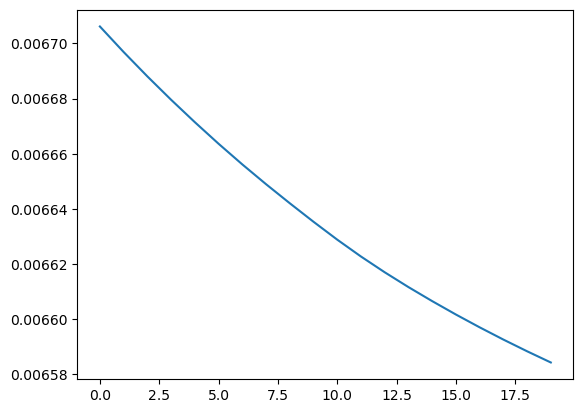

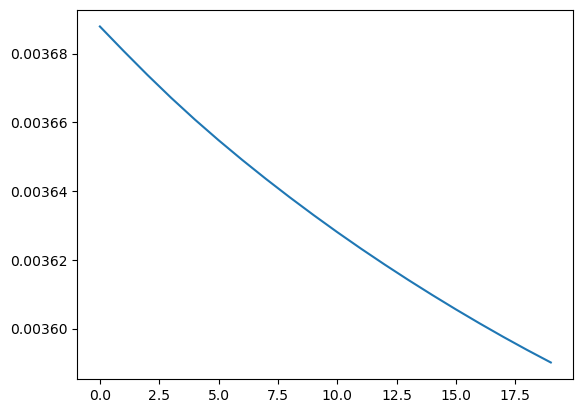

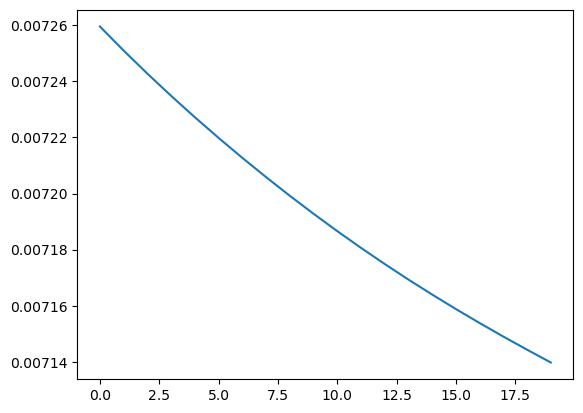

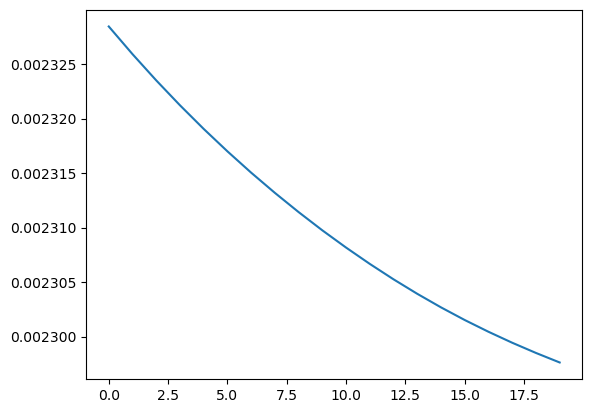

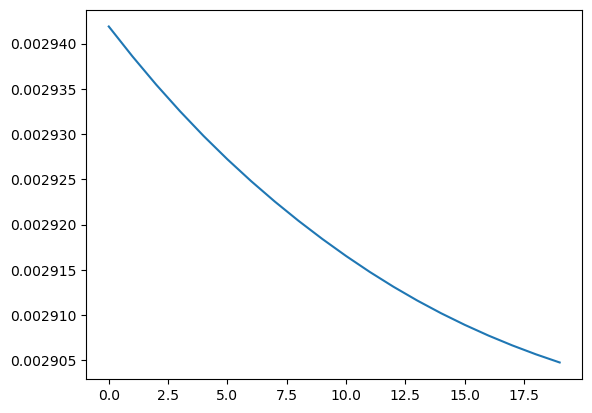

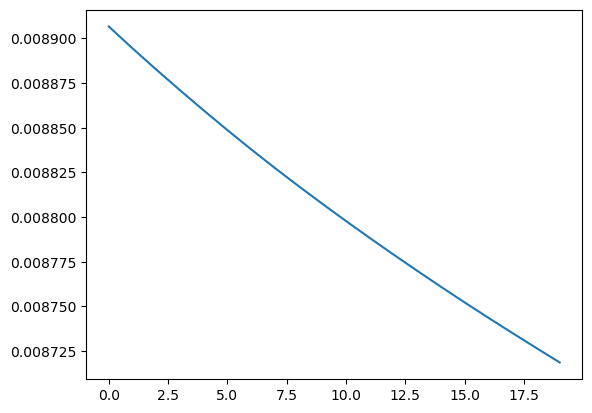

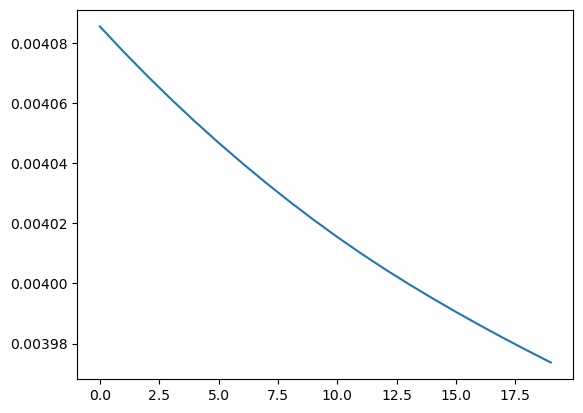

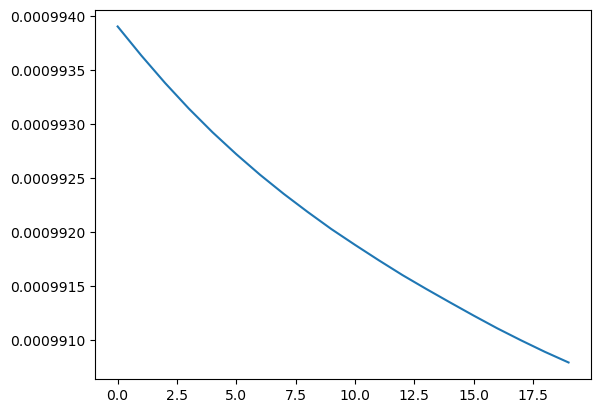

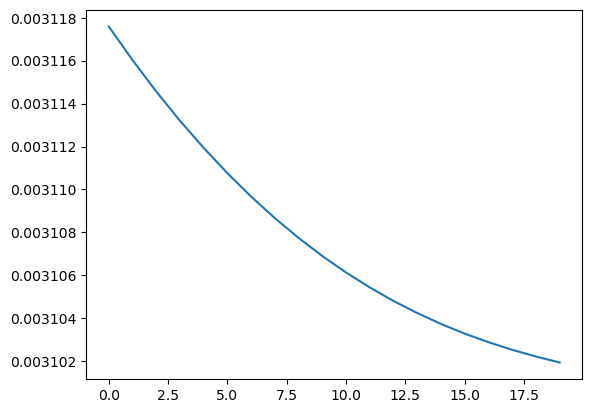

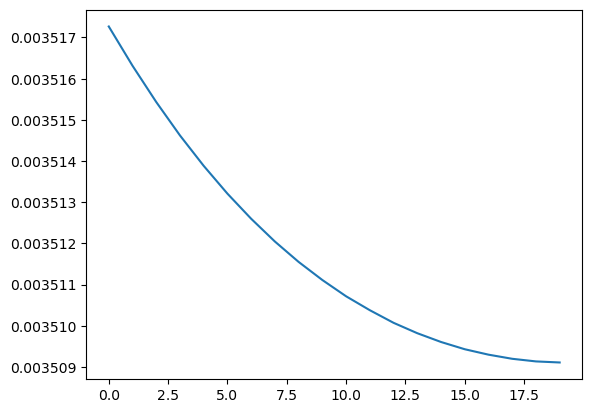

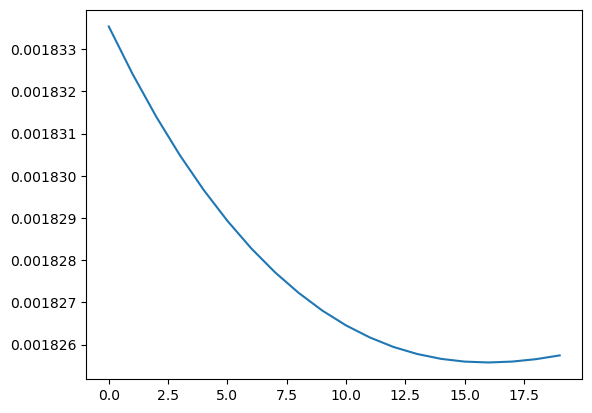

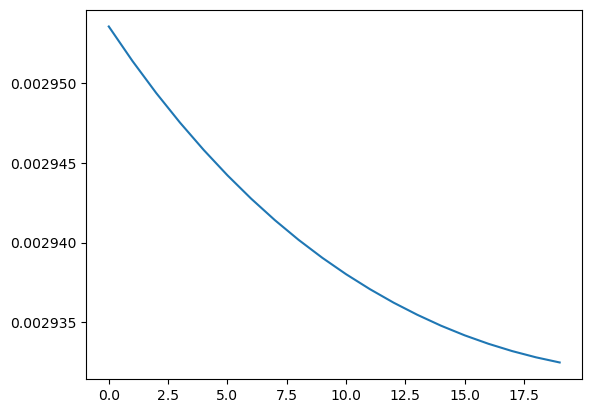

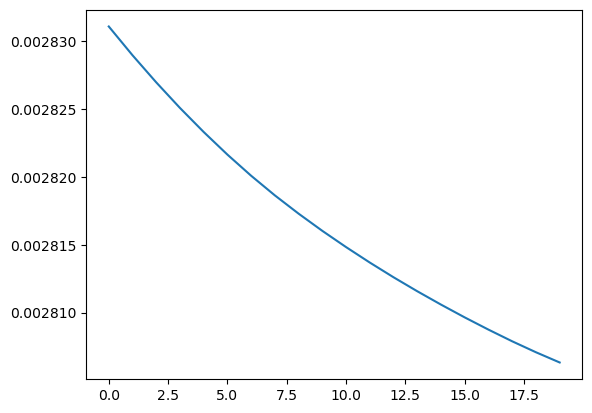

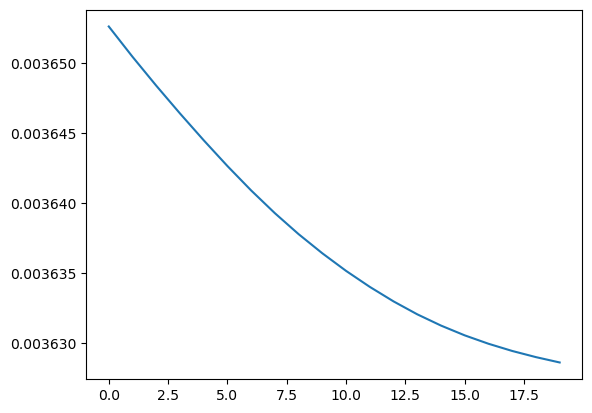

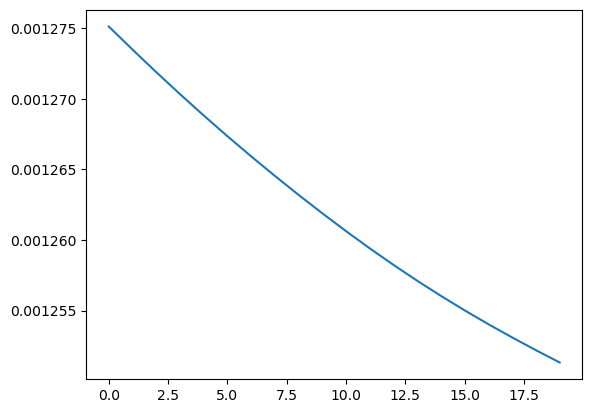

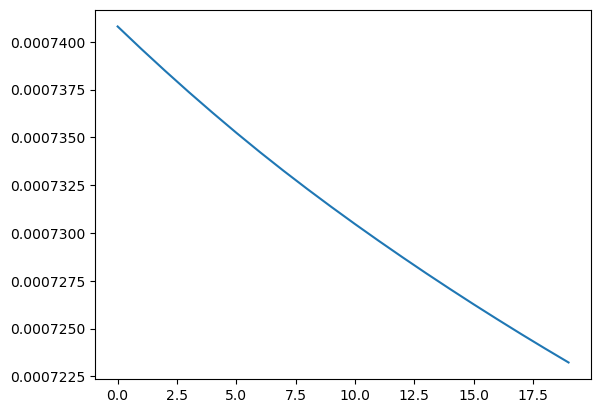

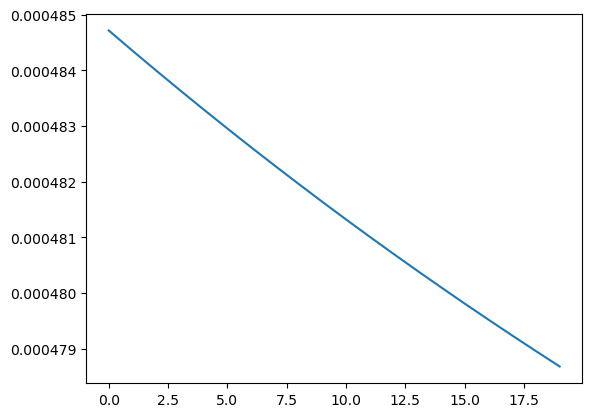

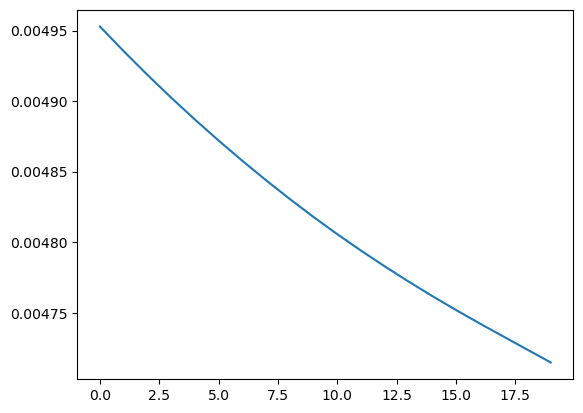

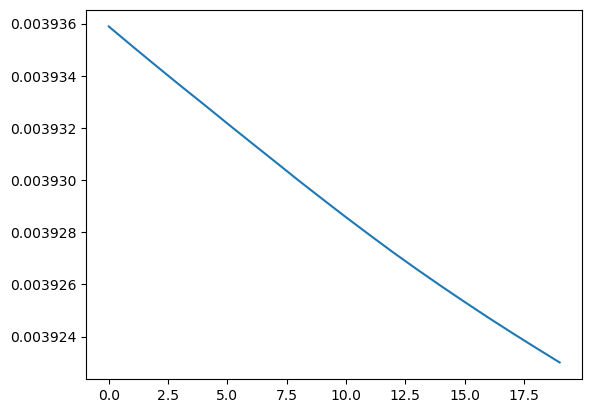

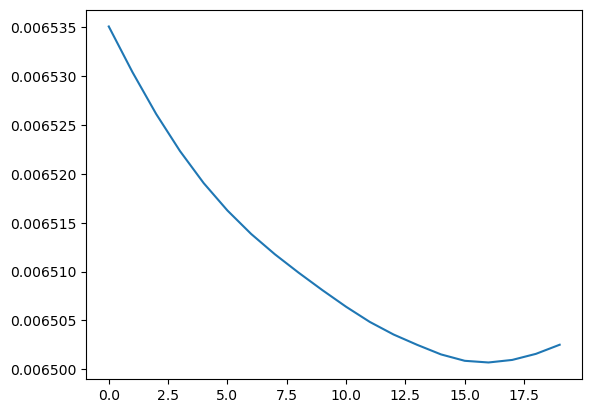

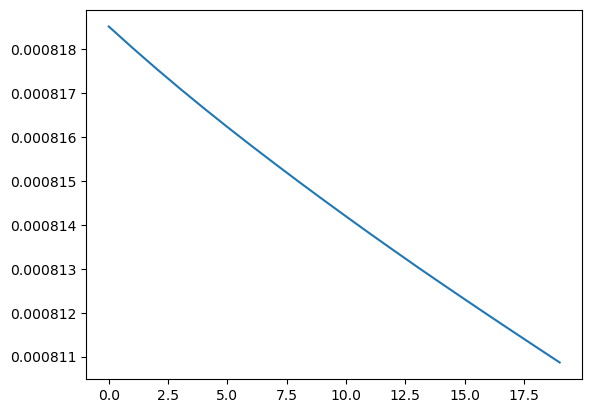

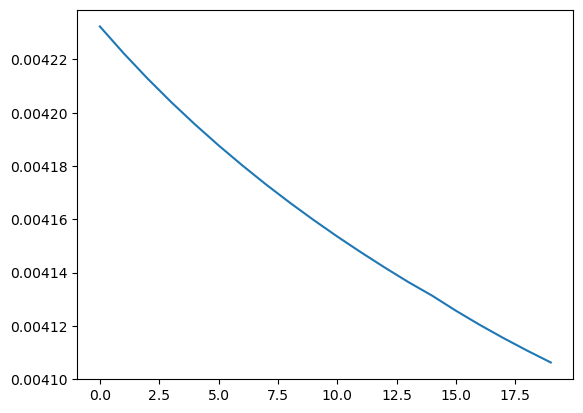

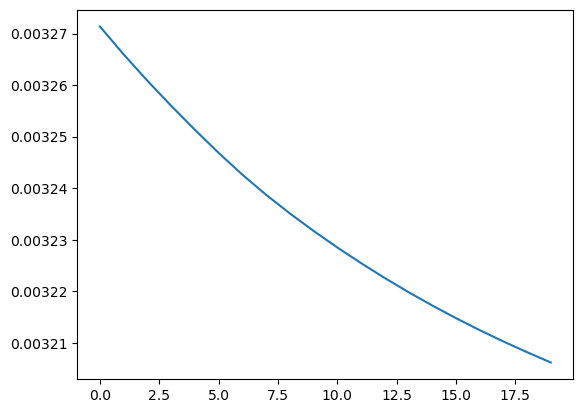

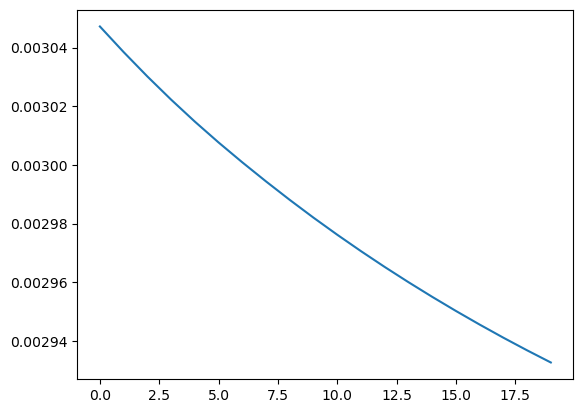

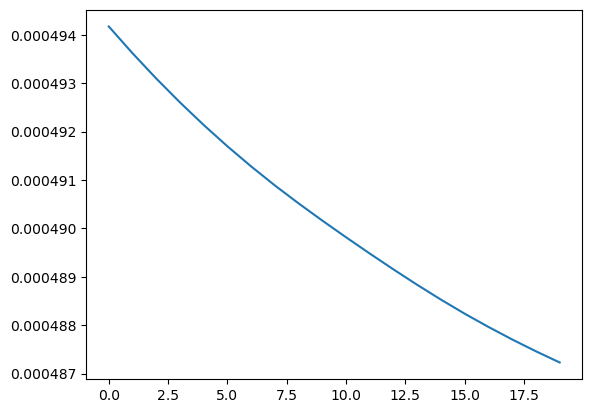

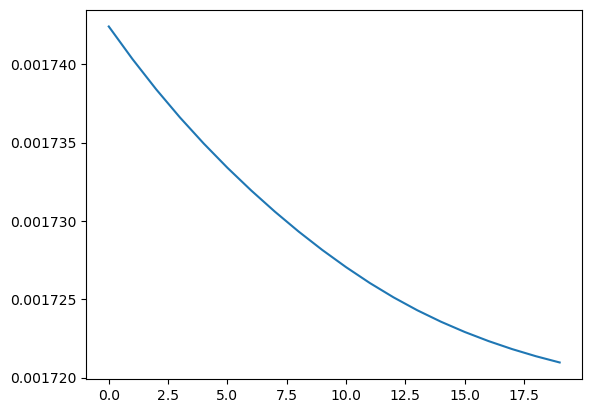

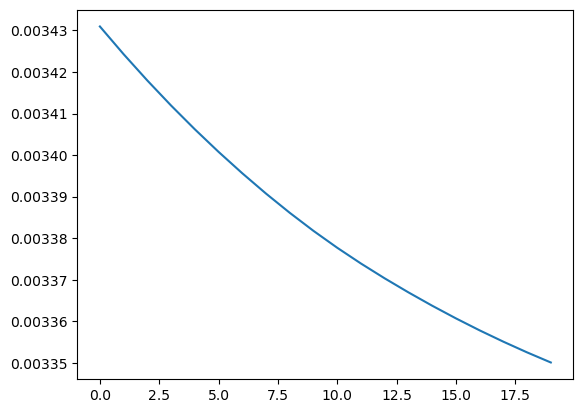

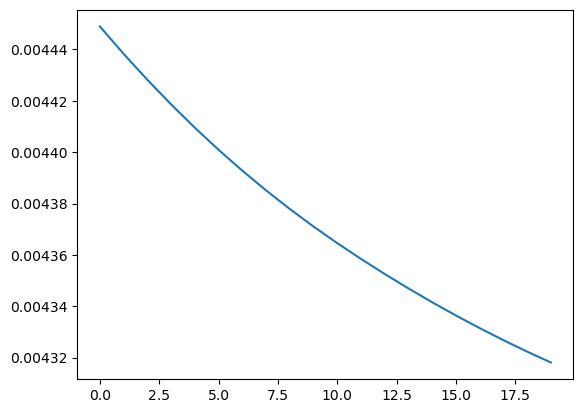

In [25]:
for tl in test_losses:
    plt.plot(tl[-20:])
    plt.show()

In [27]:
s = 0

for tl in train_losses:
    s += np.min(tl)

(s/36) ** 0.5

0.019982294296473625

In [29]:
(s/36) 

0.0003992920853508824

In [14]:
X_train.shape

(1261, 36, 48)